# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [3]:
#### word embedding pipeline

from gensim.utils import deaccent
from nltk import pos_tag
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

import re
import time

import pandas as pd
import json

import pickle
import nltk
nltk.download('averaged_perceptron_tagger')

#
LOAD_FILES = True

#d_evidence = pd.read_json("data/evidence.json", typ='series')

lemmatizer = WordNetLemmatizer()

# contraction_dict from WS7
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# https://stackoverflow.com/a/46231553
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 


def sentence_preprocessing(sentence):

    out_list = []
    # Use gensim deaccent to match more characters to [a-z]
    sentence = deaccent(sentence.lower())

    for old, new in contraction_dict.items():
        sentence.replace(old, new)

    tokenized = word_tokenize(sentence)

    # now remove all tokens that don't contain any alphanumeric characters
    # then strip non alphanumeric characters afterwards
    tokenized = [re.sub(r"[^a-z0-9\s]", "", token) for token in tokenized if re.match(r"[a-z0-9\s]", token)]

    # now lemmatize with pos
    tagged = pos_tag(tokenized)
    for token, tag in tagged:
        wntag = get_wordnet_pos(tag)

        if wntag is None: # do not supply tag in case of None
            lemma = lemmatizer.lemmatize(token) 
        else:
            lemma = lemmatizer.lemmatize(token, pos=wntag) 

        out_list.append(lemma)
    
    return out_list


def evidence_preprocessing(evidences):
  t = time.time()
  processed = []
  for index, item in enumerate(evidences.items()):
    id, evidence = item

    row = []
    
    row.append(id)
    row.append(evidence)

    # break the text into sentences before tokenizing by each sentence
    processed_sentences = [sentence_preprocessing(sentence) for sentence in sent_tokenize(evidence)]
    row.append(processed_sentences)


    # Appending an empty list to populate with embeddings later
    row.append([])

    processed.append(row)

    if (index + 1) % 50000 == 0:
        print(f"{time.time() - t:.2f} - {index+1} rows processed")

  return pd.DataFrame(processed, columns = ["id", "raw evidence", "processed evidence", "embeddings"])


# Evidence processing
if not LOAD_FILES:
    evidence = evidence_preprocessing(d_evidence)
    with open("../pipeline/evidence_preprocessed_v3.pkl", "wb") as f:
        pickle.dump(evidence, f)
else:
    with open("../pipeline/evidence_preprocessed_v3.pkl", "rb") as f:
        evidence = pickle.load(f)
    
    evidence.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
from gensim.utils import deaccent
from nltk import pos_tag
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

import re
import time

import pandas as pd
import json

import pickle
import nltk
nltk.download('averaged_perceptron_tagger')

#d_evidence = pd.read_json("data/evidence.json", typ='series')

lemmatizer = WordNetLemmatizer()

# contraction_dict from WS7
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}




# https://stackoverflow.com/a/46231553
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 
    
def sentence_preprocessing(sentence):

    out_list = []
    # Use gensim deaccent to match more characters to [a-z]
    sentence = deaccent(sentence.lower())

    for old, new in contraction_dict.items():
        sentence.replace(old, new)

    tokenized = word_tokenize(sentence)

    # now remove all tokens that don't contain any alphanumeric characters
    # then strip non alphanumeric characters afterwards
    tokenized = [re.sub(r"[^a-z0-9\s]", "", token) for token in tokenized if re.match(r"[a-z0-9\s]", token)]

    # now lemmatize with pos
    tagged = pos_tag(tokenized)
    for token, tag in tagged:
        wntag = get_wordnet_pos(tag)

        if wntag is None: # do not supply tag in case of None
            lemma = lemmatizer.lemmatize(token) 
        else:
            lemma = lemmatizer.lemmatize(token, pos=wntag) 

        out_list.append(lemma)
    
    return out_list


# https://huggingface.co/learn/nlp-course/chapter6/6
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

# adapted from https://huggingface.co/learn/nlp-course/chapter6/6
def tokenize(sentence):

    # janky workaround for preprocessed sentences
    if type(sentence) is not list:
        sentence = sentence_preprocessing(sentence)
        
    encoded_words = [encode_word(word) for word in sentence]
    return sum(encoded_words, [])



with open("../pipeline/BPETokenizer_merge_rules_v1.5.pkl", "rb") as f:
    merge_rules = pickle.load(f)
    

# Reconstruct vocab from merge rules due to lack of foresight
# This grabs all vocab of length 2 or above (if contains first letter)
# or 4 or above (##__)
vocab = [v for v in merge_rules.values()]

# So iterate through merge rules again to find starting letters
# and one letter suffixes
for pair, merge in merge_rules.items():
    if len(pair[0]) == 1 and pair[0] not in vocab:
        vocab.append(pair[0])
    if len(pair[1]) == 3 and pair[1] not in vocab:
        vocab.append(pair[1])


def processed_evidence_to_bpe(paragraph):
    # 2d array -> paragraph
    if type(paragraph[0]) is list:
        return [tokenize(sentence) for sentence in paragraph]

    # 1 sentence -> tokenize as is 
    else:
        return tokenize(paragraph)


counter = 0
def processed_evidence_to_bpe(paragraph):
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(f"{counter} rows processed")
    #2d array -> paragraph
    if type(paragraph[0]) is list:
        return [tokenize(sentence) for sentence in paragraph]

    # 1 sentence -> tokenize as is 
    else:
        return tokenize(paragraph)


# Save

"""
e["bpe evidence"] = e["processed evidence"].apply(processed_evidence_to_bpe)
with open("BPETokenized_evidence_v3.pkl", "wb") as f:
    pickle.dump(e, f)
"""

# Load
with open("../pipeline/BPETokenized_evidence_v3.pkl", "rb") as f:
    evidence = pickle.load(f)

"""
sentences = []

for paragraph in evidence["bpe evidence"]:
    if type(paragraph[0]) is list:
        for sentence in paragraph:
            sentences.append(sentence)
    else:
        sentences.append(paragraph)
"""

# Now do word2vec
from gensim.models import Word2Vec


EMBEDDING_DIM = 200
"""
embedding_model = Word2Vec(sentences=sentences,
                           vector_size=EMBEDDING_DIM,
                           window=4,
                           min_count=3,
                           workers=10,
                           negative=5
                           )

version = 3
with open(f"BPE Tokenizer to embedding/embeddings_BPE_v{version}.pkl", "wb") as f:
    pickle.dump(embedding_model, f)
"""

# Load embedding
with open("../pipeline/embeddings_BPE_v3.pkl", "rb") as f:
    embedding_model = pickle.load(f)

import numpy as np
def sentence_embedding(sentence):

  # Failsafe
  if len(sentence) == 0:
    return np.zeros(EMBEDDING_DIM)

  if type(sentence[0]) is not list:
      sentence = tokenize(sentence)

  # Check again here as sentence list can be empty after tokenisation (e.g. sentence = '  ')
  if len(sentence) == 0:
    return np.zeros(EMBEDDING_DIM)


  embedding = np.zeros(EMBEDDING_DIM)
  for word in sentence:
    word_embedding = np.zeros(EMBEDDING_DIM)

    # get word vector for given word
    # if not found, ignore (treat as having the zero vector)
    try:
      word_embedding = embedding_model.wv[str(word)]
    except KeyError:
      pass

    embedding += word_embedding

  return embedding / len(sentence)


def paragraph_embedding(paragraph):
    out = []

    # One sentence
    if type(paragraph[0]) is not list:
        return [sentence_embedding(paragraph)]

    else:
        for sentence in paragraph:
            out.append(sentence_embedding(sentence))
    return out

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Baseline retrieval: immediately use the raw embeddings to retrieve closest sentences
# Train a cutoff distance threshold.

from scipy.spatial.distance import cosine

# Similarity based on cosine similarity ([0-1], higher the more similar)
def similarity(text, evidence_ids):

    # Seems stupid and retrieving everything from w2v is probably cleaner
    # TODO: make this better
    evidence_embeddings = [evidence.loc[evidence['id'] == id, 'embeddings'].values[0] for id in evidence_ids]
    key_embedding = sentence_embedding(text)
    
    similarities = []
    for evidence_embedding in evidence_embeddings:
        similarities.append(1-cosine(key_embedding, evidence_embedding))

    return similarities


# Using 1 - fscore as the loss
def retrieval_loss(prediction, target):
    numerator = 0
    denominator = 0
    
    for p in prediction:
        if p in target:
            denominator += 2
            numerator += 2
        else:
            denominator += 1
    
    for t in target:
        if t not in prediction:
            denominator += 1
    
    return 1 - numerator/denominator

In [6]:
LOCAL_DEV = True # to switch between developing locally and on colab

if not LOCAL_DEV:
    # TODO: need to upload data files on Google Drive?
    from google.colab import drive
    drive.mount('/content/drive')

In [7]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [8]:
#Imports
import numpy as np
import torch
import pandas as pd

In [9]:
#visualising training data
if LOCAL_DEV:
    train = pd.read_json("../data/train-claims.json") # for local dev
    
else:
    train = pd.read_json("/content/drive/MyDrive/data/train-claims.json") # on colab
train = train.transpose()
train.head()


,claim_text,claim_label,evidences
claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1..."
claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]"
claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]"
claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5..."
claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72..."


In [10]:
if LOCAL_DEV:
    test = pd.read_json("../data/test-claims-unlabelled.json") # for local dev
    dev_data = pd.read_json("../data/dev-claims.json")
else:
    test = pd.read_json("/content/drive/MyDrive/data/test-claims-unlabelled.json") # on colab
test = test.transpose()
dev_data = dev_data.transpose()
test.head()

dev_data.head()


,claim_text,claim_label,evidences
claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-67732, evidence-572512]"
claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2..."
claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-889933, evidence-694262]"
claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28..."
claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-52981, evidence-264761, evidence-947..."


In [11]:
#visualising evidence data
if LOCAL_DEV:
    evidence = pd.read_json("../data/evidence.json",typ='series')
else:
    evidence = pd.read_json("/content/drive/MyDrive/data/evidence.json",typ='series')

In [12]:
print(len(evidence))
evidence.head()

1208827


evidence-0    John Bennet Lawes, English entrepreneur and ag...
evidence-1    Lindberg began his professional career at the ...
evidence-2    ``Boston (Ladies of Cambridge)'' by Vampire We...
evidence-3    Gerald Francis Goyer (born October 20, 1936) w...
evidence-4    He detected abnormalities of oxytocinergic fun...
dtype: object

In [13]:
import string
import contractions
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def preprocess_data(data: pd.Series) -> pd.Series:
  preprocessed_data = {}
  stop_words = set(stopwords.words('english'))
  stop_words.remove('not')
  for id, text in data.items():
    text = text.lower()
    text = contractions.fix(text)
    tokens = word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemmatized_tokens = [wnl.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    preprocessed_data[id] = " ".join(lemmatized_tokens)

  return pd.Series(preprocessed_data)


train_claims = train['claim_text']
test_claims = test['claim_text']
dev_claims = dev_data['claim_text']
processed_evidence = preprocess_data(evidence)
processed_test = preprocess_data(test_claims)
processed_dev = preprocess_data(dev_claims)
print(len(processed_evidence))
processed_train_claim = preprocess_data(train_claims)
processed_dev_claim = preprocess_data(dev_claims)
processed_test.head()

1208827


claim-2967               contribution waste heat global climate
claim-979     warm weather worsened recent drought included ...
claim-1609                greenland lost tiny fraction ice mass
claim-1020    global reef crisis not necessarily mean extinc...
claim-2599     small amount active substance cause large effect
dtype: object

In [15]:
processed_evidence = processed_evidence[processed_evidence.str.strip().str.len() > 0]
print(processed_evidence.head())
len(processed_evidence)

evidence-0    john bennet lawes english entrepreneur agricul...
evidence-1    lindberg began professional career age eventua...
evidence-2                boston lady cambridge vampire weekend
evidence-3    gerald francis goyer born october professional...
evidence-4    detected abnormality oxytocinergic function sc...
dtype: object


1207974

In [16]:
# testing:
evidence_embeddings = np.array([sentence_embedding(' ') for sentence in processed_evidence[:1000]])
print(evidence_embeddings)




[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
# Try to use the model on unseen test claims:
# Get all evidences that are likely to be relevant using a similarity score

# Vectorizing preprocessed text
# TODO: replace Tfidf with contextual embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

USE_EMBEDDING = False

vectorizer = TfidfVectorizer()
all_texts = pd.concat([processed_evidence, processed_train_claim])
vectorizer.fit(all_texts)

if not USE_EMBEDDING:
    evidence_tfidf = vectorizer.transform(processed_evidence)
    test_tfidf = vectorizer.transform(processed_test)
    train_tfidf = vectorizer.transform(processed_train_claim)
    dev_tfidf = vectorizer.transform(processed_dev)

    # TODO: replace with embeddings:
    similarity_matrix = cosine_similarity(test_tfidf, evidence_tfidf)
    dev_similarity_matrix = cosine_similarity(dev_tfidf, evidence_tfidf)
    train_similarity_matrix = cosine_similarity(train_tfidf, evidence_tfidf)
else:

    evidence_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_evidence])
    test_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_test])
    train_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_train_claim])
    dev_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_dev])

    similarity_matrix = cosine_similarity(test_embeddings, evidence_embeddings)
    dev_similarity_matrix = cosine_similarity(dev_embeddings, evidence_embeddings)
    train_similarity_matrix = cosine_similarity(train_embeddings, evidence_embeddings)




In [26]:
TOP_N_TRAIN = 20
TOP_N_TEST = 20

def getTopN(similarity_matrix, test, evidence, n):
    test = test.to_frame(name='claim_text')
    top_indices = np.argsort(-similarity_matrix, axis = 1)[:, :n]
    top_evidence = [[str(evidence.index[i]) for i in row] for row in top_indices]
    test['evidences'] = top_evidence

    
    return test

test_with_evi = getTopN(similarity_matrix, processed_test, processed_evidence, TOP_N_TRAIN)
test_with_evi.head()

dev_with_evi = getTopN(dev_similarity_matrix, processed_dev, processed_evidence, TOP_N_TRAIN)
train_with_evi = getTopN(train_similarity_matrix, processed_train_claim, processed_evidence, TOP_N_TRAIN)


In [ ]:
# Get evidence with different values of N

TOP_N_VALUES = [5, 10, 20, 50, 100, 200]  # Values of N to iterate over
top_train_results = {n: getTopN(train_similarity_matrix, processed_train_claim, processed_evidence, n) for n in TOP_N_VALUES}

claim-1937    not scientific evidence pollutant higher conce...
claim-126     el niño drove record high global temperature s...
claim-2510                              pdo switched cool phase
claim-2021    weather channel john coleman provided evidence...
claim-2449    january capped month period global temperature...
                                    ...                        
claim-1504    climate scientist say aspect case hurricane ha...
claim-243     assessment report ipcc estimated human emissio...
claim-2302    since mid global temperature warming around de...
claim-502     abnormal temperature spike february earlier mo...
claim-3093    sending oscillating microwave antenna inside v...
Length: 1228, dtype: object


{5: {'true_evidence_count': 4122, 'true_evidence_found': 411, 'unrelated_evidence_found': 5729, 'claims_with_all_evidence': 31}, 10: {'true_evidence_count': 4122, 'true_evidence_found': 585, 'unrelated_evidence_found': 11695, 'claims_with_all_evidence': 58}, 15: {'true_evidence_count': 4122, 'true_evidence_found': 689, 'unrelated_evidence_found': 17731, 'claims_with_all_evidence': 69}, 20: {'true_evidence_count': 4122, 'true_evidence_found': 780, 'unrelated_evidence_found': 23780, 'claims_with_all_evidence': 83}}
1228
83


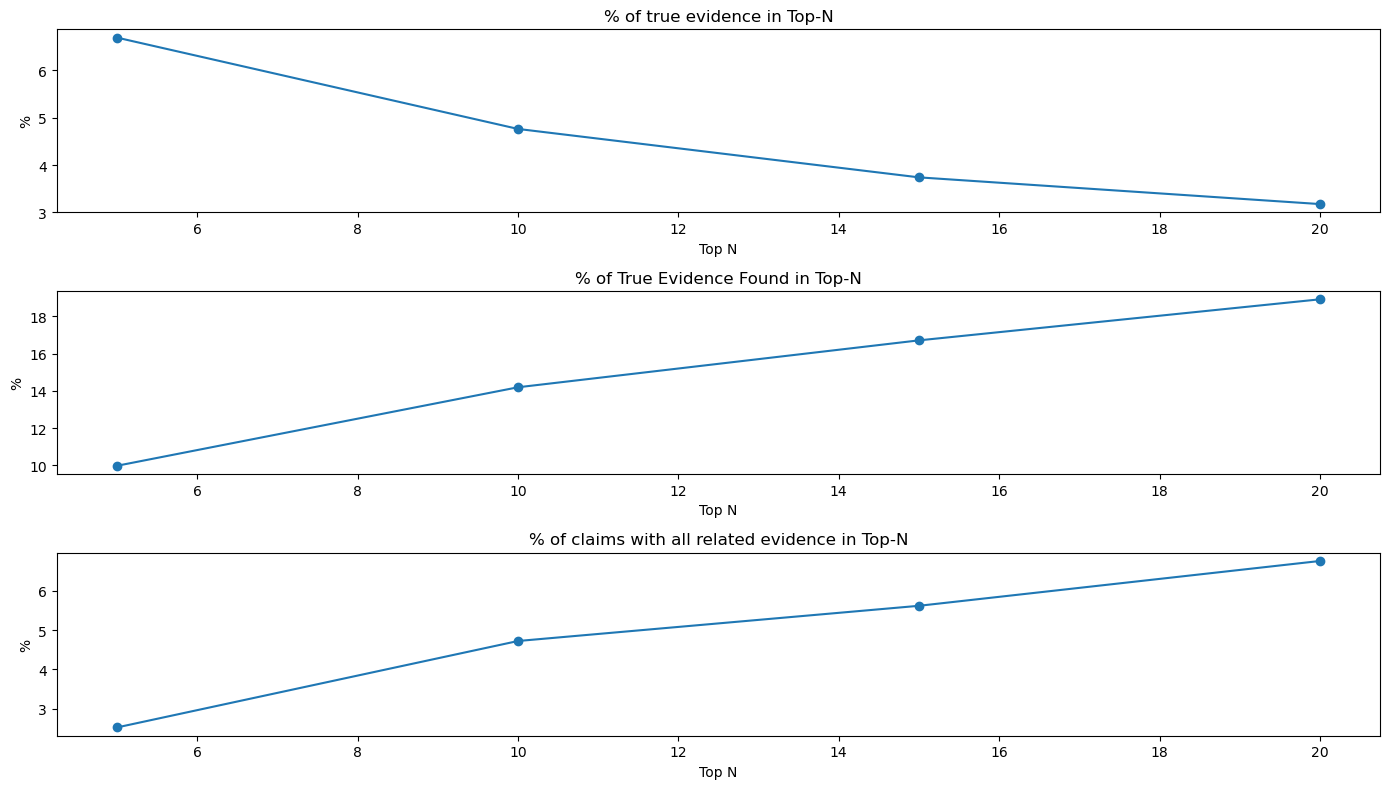

In [45]:
import matplotlib.pyplot as plt

# check effect of N on the list of evidence found


def evaluate_top_n(similar_claim_evidence, true_claim_evidence, top_n):
    # Dictionary to store analysis results
    analysis_results = {
        'true_evidence_count': 0,
        'true_evidence_found': 0,
        'unrelated_evidence_found': 0,
        'claims_with_all_evidence': 0
    }

    for index, row in true_claim_evidence.iterrows():
        if index in similar_claim_evidence.index:
            similar_claim_evidence_row = similar_claim_evidence.loc[index]
        else:
            print(f"{index} NOT FOUND IN TOP N EVIDENCE!")
            print(similar_claim_evidence.index)
            continue
        
        true_evidence_list = row['evidences']
        similar_evidence_list = similar_claim_evidence_row['evidences']
        false_evidence_list = list(set(similar_evidence_list) - set(true_evidence_list))

        analysis_results['true_evidence_count'] += len(true_evidence_list)
        analysis_results['unrelated_evidence_found'] += len(false_evidence_list)
        analysis_results['true_evidence_found'] += len(similar_evidence_list) - len(false_evidence_list)
        
        if len(similar_evidence_list) - len(false_evidence_list) == len(true_evidence_list):
            analysis_results['claims_with_all_evidence'] += 1

    return analysis_results


evaluation_results = {n: evaluate_top_n(top_train_results[n], train, n) for n in TOP_N_VALUES}

print(evaluation_results)

evidence_found_percentage = [evaluation_results[n]['true_evidence_found'] / evaluation_results[n]['true_evidence_count'] *100 for n in TOP_N_VALUES]

related_ratio = [evaluation_results[n]['true_evidence_found'] / (evaluation_results[n]['unrelated_evidence_found'] + evaluation_results[n]['true_evidence_found'] )  * 100 for n in TOP_N_VALUES]

claims_with_all_evidence_percentage = [evaluation_results[n]['claims_with_all_evidence'] / len(processed_train_claim) *100 for n in TOP_N_VALUES]
print(len(processed_train_claim))
print(evaluation_results[20]['claims_with_all_evidence'])
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(TOP_N_VALUES, related_ratio, marker='o')
plt.title('% of true evidence in Top-N')
plt.xlabel('Top N')
plt.ylabel('%')

plt.subplot(3, 1, 2)
plt.plot(TOP_N_VALUES, evidence_found_percentage, marker='o')
plt.title('% of True Evidence Found in Top-N')
plt.xlabel('Top N')
plt.ylabel('%')

plt.subplot(3, 1, 3)
plt.plot(TOP_N_VALUES, claims_with_all_evidence_percentage, marker='o')
plt.title('% of claims with all related evidence in Top-N')
plt.xlabel('Top N')
plt.ylabel('%')


plt.tight_layout()
plt.show()

In [28]:
# format data for the transformer

SPECIAL_TOKEN = ' <SPE_TOKEN> '

def format_for_transformer(processed_evidence, similar_claim_evidence, true_claim_evidence, top_n):
    text_lst = []
    label_lst = []

    # for analysing:
    true_evidence_num = 0
    found_evidence_num = 0
    false_evidence_num = 0
    claims_with_all_evidence = 0

    for index, row in true_claim_evidence.iterrows():
        #print(index)
        if index in similar_claim_evidence.index:
            similar_claim_evidence_row = similar_claim_evidence.loc[index]
            
        else:
            print(index + " NOT FOUND IN TOP N EVIDENCE!")
            print(similar_claim_evidence.index)
            continue
        claim_text = row['claim_text']
        
        true_evidence_list = row['evidences']
        #print(len(true_evidence_list))
        similar_evidence_list = similar_claim_evidence_row['evidences']
        false_evidence_list =  list(set(similar_evidence_list) - set(true_evidence_list))


        true_evidence_num += len(true_evidence_list)
        false_evidence_num += len(false_evidence_list)
        found_evidence_num += len(similar_evidence_list) - len(false_evidence_list)
        
        if(len(similar_evidence_list) - len(false_evidence_list) == len(true_evidence_list)):
            claims_with_all_evidence +=1    

       # print(len(false_evidence_list))
        for evidence in true_evidence_list:
            if evidence not in processed_evidence.index:
                print(evidence + "may be empty/ not in english, skipping..")
                continue
            evidence_text = processed_evidence[evidence]
            text = claim_text + SPECIAL_TOKEN + evidence_text
            text_lst.append(text)
            label_lst.append('related')
        for evidence in false_evidence_list[:top_n-len(true_evidence_list)]:
            if evidence not in processed_evidence.index:
                print(evidence + "may be empty/ not in english, skipping..")
                continue
            evidence_text = processed_evidence[evidence]
            text = claim_text + SPECIAL_TOKEN + evidence_text
            text_lst.append(text)
            label_lst.append('unrelated')


    claim_evi_label = {'text': text_lst, 'label': label_lst}

    print(f"true evidence count {true_evidence_num}")
    print(f"true evidence found in top {top_n}: {found_evidence_num}")
    print(f"unrelated evidence found in top {top_n}: {false_evidence_num}")
    print(f"# claims with all evidence in top {top_n}: {claims_with_all_evidence}")
    return pd.DataFrame(claim_evi_label)

preparedTrain = format_for_transformer(processed_evidence, train_with_evi, train, TOP_N_TRAIN)
preparedDev= format_for_transformer(processed_evidence, dev_with_evi, dev_data, TOP_N_TEST)
# preparedTrain = prepareTrainData(10)
# preparedDev = prepareDevData(10)
preparedTrain
#preparedDev.head()

evidence-248690may be empty/ not in english, skipping..
true evidence count 4122
true evidence found in top 20: 780
unrelated evidence found in top 20: 23780
# claims with all evidence in top 20: 83
true evidence count 491
true evidence found in top 20: 94
unrelated evidence found in top 20: 2986
# claims with all evidence in top 20: 12


,text,label
0,Not only is there no scientific evidence that ...,related
1,Not only is there no scientific evidence that ...,related
2,Not only is there no scientific evidence that ...,related
3,Not only is there no scientific evidence that ...,unrelated
4,Not only is there no scientific evidence that ...,unrelated
...,...,...
24554,Sending oscillating microwaves from an antenna...,unrelated
24555,Sending oscillating microwaves from an antenna...,unrelated
24556,Sending oscillating microwaves from an antenna...,unrelated
24557,Sending oscillating microwaves from an antenna...,unrelated


In [20]:
# need later versions for torchtext.transforms and special
#pip install torchtext==0.18.0 

# Two steps for the this task
# first. find all relavent evidence, either use contextual embedding or similarity scoring
# second. classify the evidents into 4 classes.

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [21]:


import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms
from torch.nn.utils.rnn import pad_sequence
# No module named 'torchtext.transforms' ?

/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT

In [22]:
# tokenize and vectorise training data for relevance classification

tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(preparedTrain['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_transform = torchtext.transforms.LabelToIndex({'related': 0, 'unrelated': 1})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    text_list, label_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # should stack instead of concat?
    #text_list = torch.cat(text_list)
   
    # pad sequences to make them the same length 
    padded_sequences = pad_sequence(text_list, batch_first=True)

    return padded_sequences.to(device), label_list.to(device), offsets.to(device)

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text'] 
        label = row['label'] 
        return text, label

full_dataset = TextDataset(preparedTrain)
dev_dataset = TextDataset(preparedDev)
# train test split
#train_size = int(0.8 * len(full_dataset))

#val_size = len(full_dataset) - train_size 
# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
# use dev data instead:

train_dataloader = DataLoader(full_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)
val_dataloader = DataLoader(dev_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)

In [23]:
# initialise the relevance classification model
# NOTE: run the OOP code first!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab) # TODO: verify correctness of this

emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value

model = TransformerClassificationModel(ntokens, emsize, nhead, nhid, nlayers, 2, dropout).to(device)

NameError: name 'TransformerClassificationModel' is not defined

In [ ]:
# train model
import math
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# TODO: figure out what this does and decide if it's needed in train
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time

def train_model(train_data_loader, model):

    model.train() # Turn on the train mode
    for inputs, labels, offsets in train_data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        clipping_value = 1 # arbitrary value of your choosing
        # training unstable? https://stackoverflow.com/questions/66625645/why-does-my-pytorch-nn-return-a-tensor-of-nan
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value) # https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
        optimizer.step()


def evaluate(val_data_loader, eval_model):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.

    with torch.no_grad():
       
        for inputs, labels, offsets in val_data_loader:
          
            output = eval_model(inputs)
            # output_flat = output.view(-1, ntokens) do we need to do this?
            total_loss += len(inputs) * criterion(output, labels).item()
    return total_loss / (len(val_data_loader) - 1)




best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None
#train(dataloader, model)
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train_model(train_dataloader, model)
    val_loss = evaluate(val_dataloader, model) 
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 57.79s | valid loss 10.25 | valid ppl 28356.76
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 57.16s | valid loss  8.00 | valid ppl  2991.76
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 50.94s | valid loss  7.90 | valid ppl  2700.87
-----------------------------------------------------------------------------------------


In [ ]:
# sanity check

print(dev_dataset[0])
val_batch = next(iter(val_dataloader))
print(val_batch[0][0]) # first input
print(val_batch[1]) # labels

test_outputs = model(val_batch[0])
predicted_labels = torch.argmax(test_outputs, dim=1)

print(predicted_labels)
    

('[South Australia] has the most expensive electricity in the world. <SPE_TOKEN> citation needed south australia highest retail price electricity country', 'related')
tensor([   0,    0,   30,    1,  119, 2090,  431,    8,    1,   97,    2,    3,
        1901, 1261,  393,  371,  548, 5707,  496,  431,  346,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
from sklearn.metrics import classification_report
def get_classification_report(val_data_loader, eval_model):
    model.eval()


    y_true = []
    y_pred = []

    for inputs, labels, offsets in val_data_loader:
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        y_true += labels
        y_pred += predicted_labels
    

    return classification_report(y_true, y_pred, target_names=['related', 'unrelated'])

test_loss = evaluate(val_dataloader, best_model) 
test_report = get_classification_report(val_dataloader, best_model)

print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

print(test_report)


| End of training | test loss  7.90 | test ppl  2700.87
              precision    recall  f1-score   support

     related       0.60      0.57      0.59       491
   unrelated       0.89      0.90      0.89      1819

    accuracy                           0.83      2310
   macro avg       0.74      0.73      0.74      2310
weighted avg       0.83      0.83      0.83      2310



In [ ]:

# format test data to be put into model
def prepareTestData():
    tfidf_claim = test_with_evi['claim_text']
    tfidf_evi = test_with_evi['evidences']
    text_lst = []
    for i in range(len(tfidf_claim)):
        test_claim = tfidf_claim[i]
        evidences = tfidf_evi[i]
        for j in evidences:
            text = test_claim + SPECIAL_TOKEN + processed_evidence[j]
            text_lst.append(text)
    claim_evi = {'text': text_lst, 'label':'unrelated'} # still include the label field to avoid index error
    return pd.DataFrame(claim_evi)

preparedTest = prepareTestData()
preparedTest.head()
test_dataset = TextDataset(preparedTest)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)

In [ ]:
# manually check the results since we don't have the labels:
from collections import Counter


# print(test_dataset[0])
# test_batch = next(iter(test_dataloader))
# print(test_batch[0][0]) # first input

# test_outputs = best_model(test_batch[0])
# predicted_labels = torch.argmax(test_outputs, dim=1)
# print(predicted_labels[0])


def get_all_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        all_predictions.extend(predicted_labels.cpu().numpy())
    return all_predictions

# check class imbalance
def count_labels(predictions):
    label_counts = Counter(predictions)
    return label_counts


# get all predictions

# changed to dev data
all_predictions = get_all_predictions(best_model, val_dataloader)
print(count_labels(all_predictions))
#print(all_predictions)



Counter({1: 1842, 0: 468})


In [ ]:
# update test_with_evi with model results

def filter_relevant_evidences(claim_evidences, model_classifications, default=True):
    claims = claim_evidences['claim_text']
    evidences = claim_evidences['evidences']
    filtered_evidences = []


    classifications_index = 0
    for i in range(len(claims)):
        claim = claims[i]
        curr_evidences = evidences[i]
        curr_filtered = []
        for evidence in curr_evidences:
            # 0 => related
            
            if classifications_index < len(model_classifications) and model_classifications[classifications_index] == 0:
                curr_filtered.append(evidence)

            classifications_index += 1

        if default and len(curr_filtered) == 0:
            # keep the most similar evidence if all are deemed unrelated
            curr_filtered.append(curr_evidences[0]) 

        filtered_evidences.append(curr_filtered)
    
    print(classifications_index)
    claim_evi = {'text': claims, 'evidences': filtered_evidences, 'claim_label': 'not there yet'} #still include the label field to avoid index error 
    return pd.DataFrame(claim_evi)

#filtered_claim_evidences = filter_relevant_evidences(test_with_evi, all_predictions)
# use dev instead
print(len(all_predictions))
filtered_claim_evidences = filter_relevant_evidences(dev_with_evi, all_predictions)
filtered_claim_evidences.head()



2310
2310


,text,evidences,claim_label
claim-752,south australia expensive electricity world,[evidence-421845],not there yet
claim-375,per cent total annual global emission carbon d...,"[evidence-1140012, evidence-1011788, evidence-...",not there yet
claim-1266,mean world warmer time,[evidence-694262],not there yet
claim-871,happens zika may also good model second worryi...,"[evidence-336512, evidence-548884]",not there yet
claim-2164,greenland lost tiny fraction ice mass,[evidence-962481],not there yet


In [ ]:
# manually check some of them to ensure they are somewhat correct

# need to keep at least one for this one
print(test_claims['claim-2967'])
print('=' * 89)

print(test_claims['claim-979'])
print(evidence['evidence-178433'])
print(evidence['evidence-421870'])
print('=' * 89)

print(test_claims['claim-1609'])
print(evidence['evidence-382341'])
print(evidence['evidence-726093'])

print('=' * 89)

print(test_claims['claim-1020'])
print(evidence['evidence-382341'])
print(evidence['evidence-542625'])
print('=' * 89)
print(test_claims['claim-2599'])
print(evidence['evidence-860747'])

print('evidence-860747' in evidence)

The contribution of waste heat to the global climate is 0.028 W/m2.
“Warm weather worsened the most recent five-year drought, which included the driest four-year period on record in terms of statewide precipitation.
Another form of severe weather is drought, which is a prolonged period of persistently dry weather (that is, absence of precipitation).
This is worsened by extreme weather events caused by climate change.
Greenland has only lost a tiny fraction of its ice mass.
With widespread degradation of highly biodiverse habitats such as coral reefs and rainforests, as well as other areas, the vast majority of these extinctions are thought to be "undocumented", as the species are undiscovered at the time of their extinction, or no one has yet discovered their extinction.
The Greenland ice sheet (, ) is a vast body of ice covering , roughly 80% of the surface of Greenland.
“The global reef crisis does not necessarily mean extinction for coral species.
With widespread degradation of high

In [ ]:
# adapted from eval.py
def provided_eval(predictions, groundtruth):

    try:
        f, acc = [], []

        #iterate through the groundtruth instances
        for claim_id, claim in sorted(groundtruth.iterrows()):
            
            if claim_id in predictions.index and \
                "claim_label" in predictions.loc[claim_id] and \
                "evidences" in predictions.loc[claim_id]:
                #print(claim_id)
                #check claim level label
                instance_correct = 0.0
                if predictions.loc[claim_id]["claim_label"] == claim["claim_label"]:
                    instance_correct = 1.0
                
                #check retrieved evidences
                evidence_correct = 0
                evidence_recall = 0.0
                evidence_precision = 0.0
                evidence_fscore = 0.0
              
                if type(predictions.loc[claim_id]["evidences"]) == list and (len(predictions.loc[claim_id]["evidences"]) > 0):
                    top_six_ev = set(predictions.loc[claim_id]["evidences"])
                 
                    for gr_ev in claim["evidences"]:
                        if gr_ev in top_six_ev:
                            evidence_correct += 1
                    if evidence_correct > 0:
                        evidence_recall = float(evidence_correct) / len(claim["evidences"])
                        evidence_precision = \
                            float(evidence_correct) / len(predictions.loc[claim_id]["evidences"])
                        evidence_fscore = (2*evidence_precision*evidence_recall)/(evidence_precision+evidence_recall)

                
                # print("groundtruth =", claim)
                # print("predictions =", predictions.loc[claim_id])
                # print("instance accuracy =", instance_correct)
                # print("evidence recall =", evidence_recall)
                # print("evidence precision =", evidence_precision)
                # print("evidence fscore =", evidence_fscore, "\n\n")

                #add the metric results
                acc.append(instance_correct)
                f.append(evidence_fscore)

        #compute aggregate performance
        mean_f = np.mean(f if len(f) > 0 else [0.0])
        mean_acc = np.mean(acc if len(acc) > 0 else [0.0])
        if mean_f == 0.0 and mean_acc == 0.0:
            hmean = 0.0
        else:
            hmean = (2*mean_f*mean_acc)/(mean_f+mean_acc)

        print("Evidence Retrieval F-score (F)    =", mean_f)
        print("Claim Classification Accuracy (A) =", mean_acc)
        print("Harmonic Mean of F and A          =", hmean)
                
    except Exception as error:
        print("Error:", error)
        raise SystemExit

# print("claim-752" in filtered_claim_evidences)
# print("claim-752" in dev_data)
#print(dev_data.loc['claim-752']['claim_label'])
provided_eval(filtered_claim_evidences, dev_data)

NameError: name 'filtered_claim_evidences' is not defined

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# model adpated from workshop 8
class TransformerClassificationModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, num_classes, dropout=0.5):
        super(TransformerClassificationModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.classification_head = nn.Linear(ninp, num_classes)  # added classification head
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.classification_head.bias.data.zero_()
        self.classification_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        # print("ENCODER OUTPUT")
        # print(len(output))
        output = output.mean(dim=1)  # aggregate across all tokens TODO: check if dim is correct
        # print("AGGREGATE")
        # print(len(output))
        output = self.classification_head(output) 
        # print("FINAL")
        # print(len(output))
        return output



class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)